In [1]:
# 加载环境变量并配置自动重载
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# 多智能体调研系统

本笔记本会把前面所有组件整合到一个完整系统中。

以下是整体调研流程：

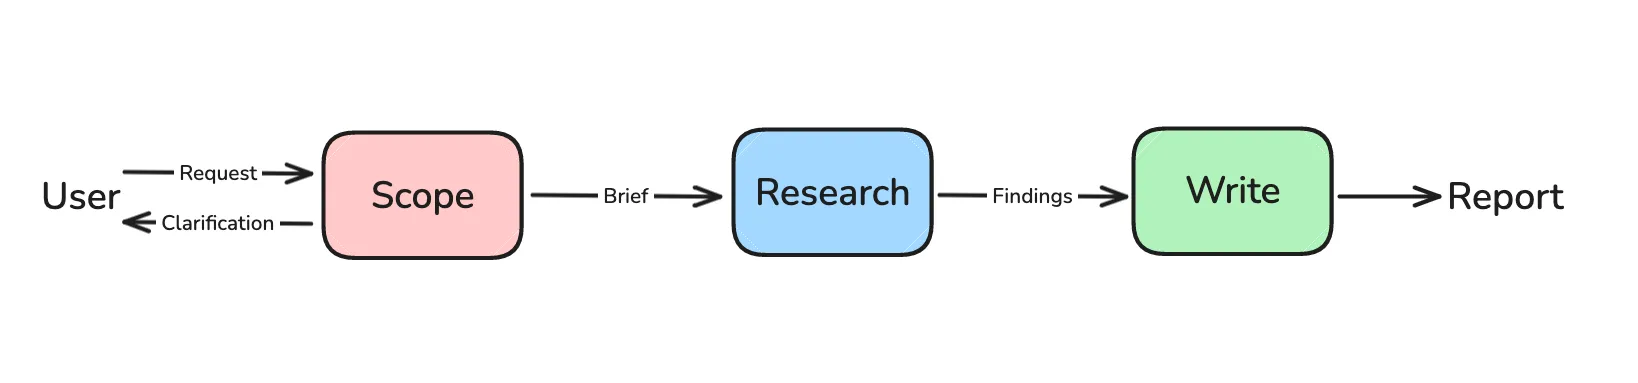

我们在之前的笔记本中已经构建了调研范围界定与多智能体调研。

现在，我们将补上最终的报告生成步骤。

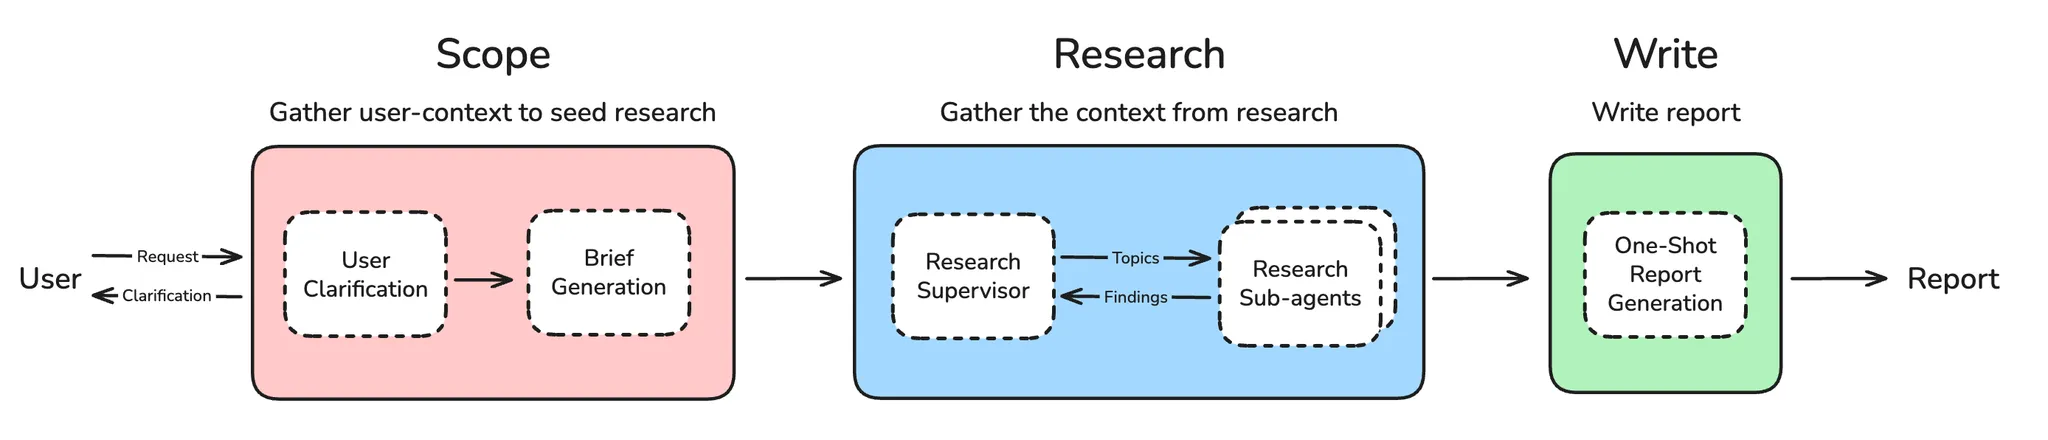

### 智能体 

我们可以直接复用已经构建好的组件。

In [2]:
%%writefile ../cn-src/deep_research_from_scratch/research_agent_full.py

"""
Full Multi-Agent Research System

This module integrates all components of the research system:
- User clarification and scoping
- Research brief generation  
- Multi-agent research coordination
- Final report generation

The system orchestrates the complete research workflow from initial user
input through final report delivery.
"""

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

from deep_research_from_scratch.utils import get_today_str
from deep_research_from_scratch.prompts import final_report_generation_prompt
from deep_research_from_scratch.state_scope import AgentState, AgentInputState
from deep_research_from_scratch.research_agent_scope import clarify_with_user, write_research_brief
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# ===== 配置 =====

# from langchain.chat_models import init_chat_model
# writer_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000) # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000
from langchain_community.chat_models import ChatTongyi
writer_model = ChatTongyi(model="qwen3-max", temperature=0)

# ===== 最终报告生成 =====

from deep_research_from_scratch.state_scope import AgentState

async def final_report_generation(state: AgentState):
    """
    Final report generation node.
    
    Synthesizes all research findings into a comprehensive final report
    """
    
    notes = state.get("notes", [])
    
    findings = "\n".join(notes)

    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        date=get_today_str()
    )
    
    final_report = await writer_model.ainvoke([HumanMessage(content=final_report_prompt)])
    
    return {
        "final_report": final_report.content, 
        "messages": ["Here is the final report: " + final_report.content],
    }

# ===== 构建图结构 =====
# 构建整体工作流
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# 添加工作流节点
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("supervisor_subgraph", supervisor_agent)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

# 添加工作流连边
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", "supervisor_subgraph")
deep_researcher_builder.add_edge("supervisor_subgraph", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

# 编译完整工作流
agent = deep_researcher_builder.compile()

Overwriting ../cn-src/deep_research_from_scratch/research_agent_full.py


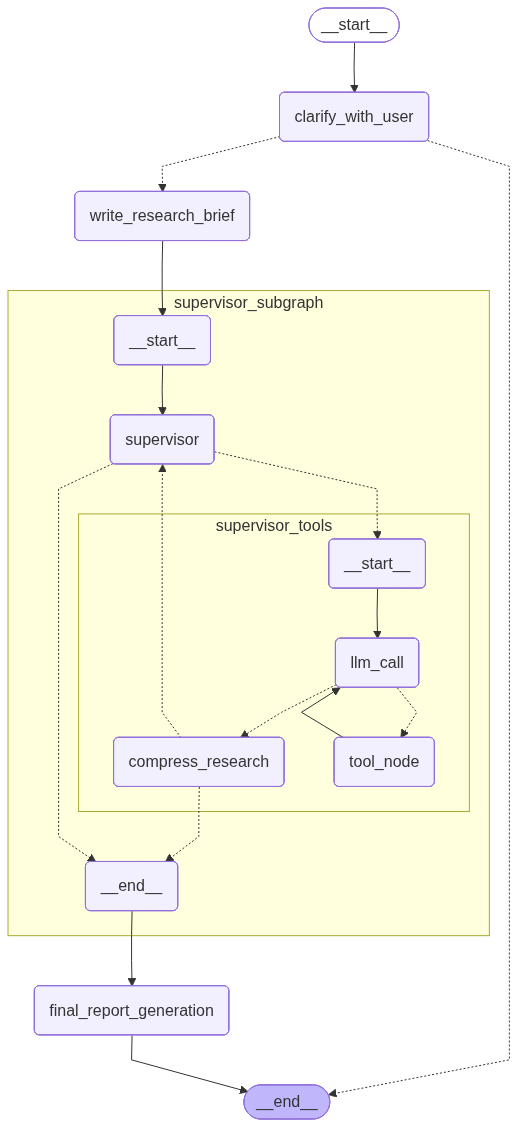

In [3]:
# 运行该工作流
from utils import format_messages
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_full import deep_researcher_builder

checkpointer = InMemorySaver()
full_agent = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

LangGraph 默认的递归深度为 25 步，用于防止无限循环。对于需要多轮迭代的复杂调研流程，需要提高这一限制。正如 [LangGraph 故障排查指南](https://langchain-ai.github.io/langgraph/troubleshooting/errors/GRAPH_RECURSION_LIMIT/) 所解释的那样，递归深度会统计图中每一次节点执行。在我们的多智能体调研系统中：

- **单个调研智能体**：调用工具与压缩通常需要 8-12 步
- **多智能体主管**：每启动一个子智能体都会增加额外步骤
- **迭代调研**：主管可能会进行多轮调研以弥补信息缺口
- **完整流程**：包括界定范围、撰写调研简报、监督调研以及生成报告

我们将递归深度设置为 **50**，以支持：
- 需要多轮调研的复杂主题
- 并行子智能体的执行
- 大量工具调用的深度调研
- 从界定范围到最终报告的完整流程

这样主管就能在初次发现仍有缺口时继续迭代调研，确保复杂主题的覆盖足够全面。

In [4]:
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1", "recursion_limit": 50}}
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Compare Gemini to OpenAI Deep Research agents.")]}, config=thread)
format_messages(result['messages'])

╭──────────────────────────────────────────────────── 🧑 用户 ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To ensure an accurate and focused comparison, could you clarify the following?                                  │
│                                                                                                                 │
│ 1. **Which specific models or versions** of Gemini (e.g., Gemini 1.5 Pro, Gemini Ultra) and OpenAI’s Deep       │
│ Research agents (e.g., o1-preview, o1-mini, or another specific agent) you’d like compared?                     │
│ 2. **Key comparison criteria**: Are you primarily interested in aspects like reasoning capabilities, research   │
│ depth, speed, accuracy, multimodal support, or other specific features?                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [6]:
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Compare Gemini Ultra with OpenAI’s Deep Research agent from full aspects")]}, config=thread)

In [7]:
format_messages(result['messages'])

╭──────────────────────────────────────────────────── 🧑 用户 ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To ensure an accurate and focused comparison, could you clarify the following?                                  │
│                                                                                                                 │
│ 1. **Which specific models or versions** of Gemini (e.g., Gemini 1.5 Pro, Gemini Ultra) and OpenAI’s Deep       │
│ Research agents (e.g., o1-preview, o1-mini, or another specific agent) you’d like compared?                     │
│ 2. **Key comparison criteria**: Are you primarily interested in aspects like reasoning capabilities, research   │
│ depth, speed, accuracy, multimodal support, or other specific features?                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── 🧑 用户 ────────────────────────────────────────────────────╮
│ Compare Gemini Ultra with OpenAI’s Deep Research agent from full aspects                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── 🧑 用户 ────────────────────────────────────────────────────╮
│ Compare Gemini Ultra with OpenAI’s Deep Research agent from full aspects                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for the clarification. I will now begin researching and comparing Gemini Ultra with OpenAI’s Deep     │
│ Research agent across all relevant aspects, including reasoning capabilities, research depth, accuracy, speed,  │
│ multimodal support, and other key features.                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── 🧑 用户 ────────────────────────────────────────────────────╮
│ Here is the final report: # Comprehensive Comparison: Gemini Ultra (Deep Research) vs. OpenAI Deep Research     │
│ Agent                                                                                                           │
│                                                                                                                 │
│ ## Introduction                                                                                                 │
│                                                                                                                 │
│ In early 2025, a new class of AI-powered research assistants emerged, led by Google’s **Gemini Deep Research**  │
│ (powered by the Gemini 2.5 model, often referred to as “Gemini Ultra” in consumer contexts) and OpenAI’s **Deep │
│ Research agent** (built on the o3 reasoning model). These systems represent a significant evolution beyond      │
│ standard large language models (LLMs), functioning as agentic researchers that autonomously plan, search,       │
│ reason, and synthesize multi-source information into comprehensive reports. This report provides a detailed,    │
│ evidence-based comparison across the explicitly requested dimensions—reasoning capabilities, research depth,    │
│ accuracy, speed, and multimodal support—as well as critical open considerations including context window        │
│ length, source citation, real-time information handling, output formatting, pricing, and user experience.       │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## Reasoning Capabilities                                                                                       │
│                                                                                                                 │
│ ### OpenAI Deep Research (o3 Model)                                                                             │
│ OpenAI’s Deep Research agent leverages the **o3 model**, described as the company’s “smartest model to date” as │
│ of April 2025 [4]. The o3 model exhibits advanced reasoning through extended internal deliberation—“thinking    │
│ longer before responding”—and makes **20% fewer major errors** than its predecessor, o1, on difficult           │
│ real-world tasks [4]. It is trained using **end-to-end reinforcement learning on real-world research tasks**,   │
│ enabling it to decompose complex queries, iteratively refine search strategies, and synthesize nuanced          │
│ conclusions [5]. In practical testing, o3 demonstrated superior prompt comprehension, identifying niche         │
│ competitors like Skillsoft and Datacamp in a competitive analysis task where other models defaulted to generic  │
│ edtech giants [9].                                                                                              │
│                                                                                                                 │
│ ### Gemini Deep Research (Gemini 2.5 / “Ultra”)                                                                 │
│ Gemini Deep Research is powered by **Gemini 2.5**, which includes a specialized **“Deep Think”** mode           │
│ introduced in August 2025 [7]. This mode employs **parallel thinking and reinforcement learning** to tackle     │
│ highly complex problems in mathematics, coding, and scientific discovery. Notably, a research-grade version of  │
│ Gemini 2.5 achieved **gold-medal performance** at the International Mathematical Olympiad (IMO), while the      │
│ consumer-facing Deep Think offers **Bronze-level IMO capa

In [8]:
from rich.markdown import Markdown
Markdown(result["final_report"])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃              Comprehensive Comparison: Gemini Ultra (Deep Research) vs. OpenAI Deep Research Agent              ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                   Introduction                                                    

In early 2025, a new class of AI-powered research assistants emerged, led by Google’s Gemini Deep Research (powered
by the Gemini 2.5 model, often referred to as “Gemini Ultra” in consumer contexts) and OpenAI’s Deep Research agent
(built on the o3 reasoning model). These systems represent a significant evolution beyond standard large language  
models (LLMs), functioning as agentic researchers that autonomously plan, search, reason, and synthesize           
multi-source information into comprehensive reports. This report provides a detailed, evidence-based comparison    
across the explicitly requested dimensions—reasoning capabilities, research depth, accuracy, speed, and multimodal 
support—as well as critical open considerations including context window length, source citation, real-time        
information handling, output formatting, pricing, and user experience.                                             

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                              Reasoning Capabilities                                               

                                          OpenAI Deep Research (o3 Model)                                          

OpenAI’s Deep Research agent leverages the o3 model, described as the company’s “smartest model to date” as of     
April 2025 [4]. The o3 model exhibits advanced reasoning through extended internal deliberation—“thinking longer   
before responding”—and makes 20% fewer major errors than its predecessor, o1, on difficult real-world tasks [4]. It
is trained using end-to-end reinforcement learning on real-world research tasks, enabling it to decompose complex  
queries, iteratively refine search strategies, and synthesize nuanced conclusions [5]. In practical testing, o3    
demonstrated superior prompt comprehension, identifying niche competitors like Skillsoft and Datacamp in a         
competitive analysis task where other models defaulted to generic edtech giants [9].                               

                                    Gemini Deep Research (Gemini 2.5 / “Ultra”)                                    

Gemini Deep Research is powered by Gemini 2.5, which includes a specialized “Deep Think” mode introduced in August 
2025 [7]. This mode employs parallel thinking and reinforcement learning to tackle highly complex problems in      
mathematics, coding, and scientific discovery. Notably, a research-grade version of Gemini 2.5 achieved gold-medal 
performance at the International Mathematical Olympiad (IMO), while the consumer-facing Deep Think offers          
Bronze-level IMO capability [7]. Despite this theoretical strength, real-world evaluations indicate that Gemini    
sometimes produces superficial or misaligned analyses, particularly when prompts require domain-specific nuance    
[9].                                                                                                               

                                              Comparative Assessment                                               

While both models exhibit state-of-the-art reasoning, OpenAI’s o3 demonstrates more consistent real-world          
analytical fidelity, especially in tasks requiring deep domain understanding and novel insight generation. Gemini’s
reasoning is robust in structured, well-defined problems (e.g., math competitions) but can falter in open-ended,   
context-sensitive research scenarios.        

我们可以在[这里](https://smith.langchain.com/public/86ebdc25-4595-4040-be1e-a8e30052786b/r)查看追踪记录。

### LangGraph Studio

同样，我们可以用 LangGraph Studio 来可视化这个智能体。 

在所有笔记本中通过 `%%writefile` 写入 `src/deep_research_from_scratch/` 的文件共同组成了应用所需的代码：

```

deep_research_from_scratch/
├── src/deep_research_from_scratch/
│   ├── state.py          # 状态定义
│   ├── scope_research.py # 界定范围的工作流
│   ├── prompts.py        # 提示模板
│   └── ...
├── notebooks/            # 开发用笔记本
├── pyproject.toml        # 依赖配置
└── langgraph.json        # LangGraph 配置
```

该智能体已经添加到 `langgraph.json` 文件里，你可以在下拉菜单选择 `research_agent_full`：

```
"research_agent_full": "./src/deep_research_from_scratch/research_agent_full.py:agent"
```

运行以下命令即可启动 Studio：

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```